In [1]:
import sympy
from sympy.tensor.tensor import TensorIndexType, TensorIndex, TensorHead, tensor_indices, TensorSymmetry
from einsteinpy.symbolic import RicciTensor, MetricTensor, ChristoffelSymbols

sympy.init_printing()

### Einstein Equation

Compute the Einstein tensor.

In [2]:
syms = sympy.symbols("r psi theta phi")
r, psi, theta, phi = syms
f = sympy.Function('f')(r)  # metric ansatz
cap_phi = sympy.Function('Phi')(r)  # defines gauge field
L = sympy.symbols("L")  # AdS length scale
r_0 = sympy.symbols("r_0")

In [3]:
list2d = [[0 for i in range(4)] for i in range(4)]
list2d[0][0] = 1 / f
list2d[1][1] = list2d[2][2] = list2d[3][3] = (r ** 2 + r_0 ** 2)/4
list2d[1][3] = list2d[3][1] = (r ** 2 + r_0 ** 2)/ 4 * sympy.cos(theta)
sch = MetricTensor(list2d, syms)
sch.tensor()

⎡ 1                                                  ⎤
⎢────          0             0              0        ⎥
⎢f(r)                                                ⎥
⎢                                                    ⎥
⎢           2     2                 ⎛ 2     2⎞       ⎥
⎢          r    r₀                  ⎜r    r₀ ⎟       ⎥
⎢ 0        ── + ───          0      ⎜── + ───⎟⋅cos(θ)⎥
⎢          4     4                  ⎝4     4 ⎠       ⎥
⎢                                                    ⎥
⎢                          2     2                   ⎥
⎢                         r    r₀                    ⎥
⎢ 0            0          ── + ───          0        ⎥
⎢                         4     4                    ⎥
⎢                                                    ⎥
⎢      ⎛ 2     2⎞                        2     2     ⎥
⎢      ⎜r    r₀ ⎟                       r    r₀      ⎥
⎢ 0    ⎜── + ───⎟⋅cos(θ)     0          ── + ───     ⎥
⎣      ⎝4     4 ⎠                       4     4      ⎦

In [4]:
Ric = RicciTensor.from_metric(sch)
Ric.tensor()

⎡  ⎛   3 d              2 d              2     ⎞                              
⎢3⋅⎜- r ⋅──(f(r)) - r⋅r₀ ⋅──(f(r)) - 2⋅r₀ ⋅f(r)⎟                              
⎢  ⎝     dr               dr                   ⎠                              
⎢───────────────────────────────────────────────                              
⎢            ⎛ 4      2   2     4⎞                                            
⎢          2⋅⎝r  + 2⋅r ⋅r₀  + r₀ ⎠⋅f(r)                                       
⎢                                                                             
⎢                                                        3 d             2    
⎢                                                     - r ⋅──(f(r)) - 4⋅r ⋅f(r
⎢                                                          dr                 
⎢                       0                             ────────────────────────
⎢                                                                             
⎢                                                   

In [5]:
metric_array = sympy.MutableDenseNDimArray(list2d)
einstein_tensor = sympy.MutableDenseNDimArray(Ric.tensor()) + 3 / L ** 2 * metric_array
einstein_tensor = sympy.simplify(einstein_tensor)
einstein_tensor

⎡  ⎛   2 ⎛ 3 d              2 d              2     ⎞      4      2   2       4
⎢3⋅⎜- L ⋅⎜r ⋅──(f(r)) + r⋅r₀ ⋅──(f(r)) + 2⋅r₀ ⋅f(r)⎟ + 2⋅r  + 4⋅r ⋅r₀  + 2⋅r₀ 
⎢  ⎝     ⎝   dr               dr                   ⎠                          
⎢─────────────────────────────────────────────────────────────────────────────
⎢                          2 ⎛ 4      2   2     4⎞                            
⎢                       2⋅L ⋅⎝r  + 2⋅r ⋅r₀  + r₀ ⎠⋅f(r)                       
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                      0                                      
⎢                                                   

Compute the right-hand side of the Einstein equation.

In [6]:
A_1 = L / 2 * cap_phi * sympy.Array([0, 0, -sympy.sin(psi), sympy.cos(psi) * sympy.sin(theta)])
A_2 = L / 2 * cap_phi * sympy.Array([0, 0, sympy.cos(psi), sympy.sin(psi) * sympy.sin(theta)])
A_3 = L / 2 * cap_phi * sympy.Array([0, 1, 0, sympy.cos(theta)])

In [7]:
A_1, A_2, A_3

⎛⎡      -L⋅Φ(r)⋅sin(ψ)   L⋅Φ(r)⋅sin(θ)⋅cos(ψ)⎤  ⎡      L⋅Φ(r)⋅cos(ψ)  L⋅Φ(r)⋅s
⎜⎢0  0  ───────────────  ────────────────────⎥, ⎢0  0  ─────────────  ────────
⎝⎣             2                  2          ⎦  ⎣            2                

in(ψ)⋅sin(θ)⎤  ⎡   L⋅Φ(r)     L⋅Φ(r)⋅cos(θ)⎤⎞
────────────⎥, ⎢0  ──────  0  ─────────────⎥⎟
 2          ⎦  ⎣     2              2      ⎦⎠

In [8]:
x = [r, psi, theta, phi]
def em_field_strength(A):
    """Compute EM field strength from the vector potential."""    
    F = sympy.MutableDenseNDimArray.zeros(4, 4)
    for i in range(4):
        for j in range(4):
            F[i, j] = sympy.diff(A[j], x[i]) - sympy.diff(A[i], x[j])
    return F

In [9]:
F_1 = em_field_strength(A_1)
F_2 = em_field_strength(A_2)
F_3 = em_field_strength(A_3)

Compute the first term in the energy momentum tensor, involving two field strength tensors with one contraction.

In [10]:
metric_inv = sympy.Matrix(metric_array).inv()
metric_inv

⎡f(r)                   0                      0                       0      
⎢                                                                             
⎢                      -4                                           4⋅cos(θ)  
⎢ 0    ───────────────────────────────────     0      ────────────────────────
⎢       2    2       2     2    2        2             2    2       2     2   
⎢      r ⋅cos (θ) - r  + r₀ ⋅cos (θ) - r₀             r ⋅cos (θ) - r  + r₀ ⋅co
⎢                                                                             
⎢                                              4                              
⎢ 0                     0                   ────────                   0      
⎢                                            2     2                          
⎢                                           r  + r₀                           
⎢                                                                             
⎢                    4⋅cos(θ)                       

Wrap into a tensor object with appropriate indices.

In [11]:
Euclidean = TensorIndexType('Euclidean', dummy_name='E')
i0, i1, i2, i3, i4, i5, i6, i7 = tensor_indices('i0:8', Euclidean)

In [12]:
FFg_tensor = TensorHead('FFg', [Euclidean] * 6)
FFg_matrix = (
    sympy.tensorproduct(F_1, F_1, metric_inv) +
    sympy.tensorproduct(F_2, F_2, metric_inv) +
    sympy.tensorproduct(F_3, F_3, metric_inv)
)
repl = {FFg_tensor(-i0, -i1, -i2, -i3, i4, i5): FFg_matrix}

Contract indices.

In [13]:
T_contracted_1 = FFg_tensor(-i0, -i1, -i2, -i3, i3, i1).replace_with_arrays(repl)
T_contracted_1 = sympy.simplify(T_contracted_1)
T_contracted_1

⎡               2                                                             
⎢   2 ⎛d       ⎞                                                              
⎢3⋅L ⋅⎜──(Φ(r))⎟                                                              
⎢     ⎝dr      ⎠                                                              
⎢────────────────                                 0                           
⎢     2     2                                                                 
⎢    r  + r₀                                                                  
⎢                                                                             
⎢                        ⎛                  2                      2          
⎢                      2 ⎜ 2      ⎛d       ⎞      2      ⎛d       ⎞       2   
⎢                     L ⋅⎜r ⋅f(r)⋅⎜──(Φ(r))⎟  + r₀ ⋅f(r)⋅⎜──(Φ(r))⎟  + 8⋅Φ (r)
⎢                        ⎝        ⎝dr      ⎠             ⎝dr      ⎠           
⎢       0             ──────────────────────────────

Compute second term of the energy momentum tensor involving two contractions.

In [14]:
FFgg_tensor = TensorHead('FFgg', [Euclidean] * 8)
FFgg_matrix = (
    sympy.tensorproduct(F_1, F_1, metric_inv, metric_inv) +
    sympy.tensorproduct(F_2, F_2, metric_inv, metric_inv) +
    sympy.tensorproduct(F_3, F_3, metric_inv, metric_inv)
)
repl = {FFgg_tensor(-i0, -i1, -i2, -i3, i4, i5, i6, i7): FFgg_matrix}

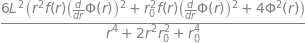

In [15]:
T_contracted_2 = FFgg_tensor(-i0, -i1, -i2, -i3, i3, i1, i2, i0).replace_with_arrays(repl)
T_contracted_2.simplify()

Compute the energy-momentum tensor.

In [16]:
energy_momentum = 2 * (T_contracted_1 - metric_array / 4 * T_contracted_2)
energy_momentum = sympy.simplify(energy_momentum)
energy_momentum

⎡     ⎛                  2                      2          ⎞                  
⎢   2 ⎜ 2      ⎛d       ⎞      2      ⎛d       ⎞       2   ⎟                  
⎢3⋅L ⋅⎜r ⋅f(r)⋅⎜──(Φ(r))⎟  + r₀ ⋅f(r)⋅⎜──(Φ(r))⎟  - 4⋅Φ (r)⎟                  
⎢     ⎝        ⎝dr      ⎠             ⎝dr      ⎠           ⎠                  
⎢───────────────────────────────────────────────────────────                  
⎢                 ⎛ 4      2   2     4⎞                                       
⎢                 ⎝r  + 2⋅r ⋅r₀  + r₀ ⎠⋅f(r)                                  
⎢                                                                             
⎢                                                                    ⎛        
⎢                                                                    ⎜   2    
⎢                                                                    ⎜  r ⋅f(r
⎢                                                                  2 ⎜        
⎢                                                   

Inspect equations.

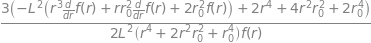

In [17]:
einstein_tensor[0, 0]

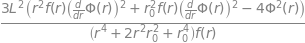

In [18]:
energy_momentum[0, 0]

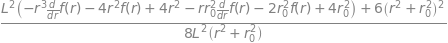

In [19]:
einstein_tensor[1, 1]

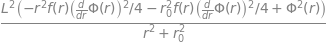

In [20]:
energy_momentum[1, 1]

### Maxwell Equations

In [21]:
ch = ChristoffelSymbols.from_metric(sch)
ch = ch.tensor().simplify()
ch

⎡⎡ d                                                    ⎤  ⎡             r    
⎢⎢-──(f(r))                                             ⎥  ⎢   0      ────────
⎢⎢ dr                                                   ⎥  ⎢           2     2
⎢⎢──────────         0            0             0       ⎥  ⎢          r  + r₀ 
⎢⎢  2⋅f(r)                                              ⎥  ⎢                  
⎢⎢                                                      ⎥  ⎢   r              
⎢⎢               -r⋅f(r)                 -r⋅f(r)⋅cos(θ) ⎥  ⎢────────     0    
⎢⎢    0          ────────         0      ───────────────⎥  ⎢ 2     2          
⎢⎢                  4                           4       ⎥  ⎢r  + r₀           
⎢⎢                                                      ⎥  ⎢                  
⎢⎢                             -r⋅f(r)                  ⎥  ⎢             1    
⎢⎢    0              0         ────────         0       ⎥  ⎢   0      ────────
⎢⎢                                4                 

Raise indices on the field strength tensor.

In [22]:
Fgg_tensor = TensorHead('Fgg', [Euclidean] * 6)
Fgg_matrix = sympy.tensorproduct(F_3, metric_inv, metric_inv)
repl = {Fgg_tensor(-i0, -i1, i2, i3, i4, i5): Fgg_matrix}
F_upper_indices = Fgg_tensor(-i0, -i1, i0, i2, i1, i3).replace_with_arrays(repl)
F_upper_indices = sympy.simplify(F_upper_indices)
F_upper_indices

⎡                              d                                              
⎢                     2⋅L⋅f(r)⋅──(Φ(r))                                       
⎢                              dr                                             
⎢         0           ─────────────────           0                   0       
⎢                           2     2                                           
⎢                          r  + r₀                                            
⎢                                                                             
⎢          d                                                                  
⎢-2⋅L⋅f(r)⋅──(Φ(r))                                                           
⎢          dr                                 -8⋅L⋅Φ(r)                       
⎢───────────────────          0           ──────────────────          0       
⎢       2     2                                     2                         
⎢      r  + r₀                            ⎛ 2     2⎞

In [23]:
F_3

⎡                       d                                 d       ⎤
⎢                     L⋅──(Φ(r))                 L⋅cos(θ)⋅──(Φ(r))⎥
⎢                       dr                                dr      ⎥
⎢         0           ──────────        0        ─────────────────⎥
⎢                         2                              2        ⎥
⎢                                                                 ⎥
⎢      d                                                          ⎥
⎢   -L⋅──(Φ(r))                                                   ⎥
⎢      dr                                                         ⎥
⎢   ────────────          0             0                0        ⎥
⎢        2                                                        ⎥
⎢                                                                 ⎥
⎢                                                 -L⋅Φ(r)⋅sin(θ)  ⎥
⎢         0               0             0         ─────────────── ⎥
⎢                                               

Compute partial derivative of field strength.

In [24]:
partial_F = sympy.MutableDenseNDimArray.zeros(4, 4, 4)
for i in range(4):
    for j in range(4):
        for k in range(4):
            partial_F[i, j, k] = sympy.diff(F_upper_indices[j, k], x[i]) 

In [25]:
sympy.simplify(partial_F[0])

⎡                                                                             
⎢                                                                             
⎢                                                                           2⋅
⎢                                                                             
⎢                                                                             
⎢                                    0                                      ──
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢    ⎛                               ⎛       2                          ⎞⎞    
⎢    ⎜         d          ⎛ 2     2⎞ ⎜      d          d        d       ⎟⎟    
⎢2⋅L⋅⎜2⋅r⋅f(r)⋅──(Φ(r)) - ⎝r  + r₀ ⎠⋅⎜f(r)⋅───(Φ(r))

In [26]:
partial_F_tensor = TensorHead('partialF', [Euclidean] * 3)
repl = {partial_F_tensor(-i0, i1, i2): partial_F}
partial_F_contracted = partial_F_tensor(-i0, i0, i1).replace_with_arrays(repl)

Add contractions with Christoffel symbols.

In [27]:
lambda_F_tensor = TensorHead('lambdaF', [Euclidean] * 5)
lambda_F_matrix = sympy.tensorproduct(ch, F_upper_indices)
repl = {lambda_F_tensor(i0, -i1, -i2, i3, i4): lambda_F_matrix}
partial_F_contracted += lambda_F_tensor(i0, -i0, -i1, i1, i2).replace_with_arrays(repl)
partial_F_contracted += lambda_F_tensor(i0, -i1, -i2, i1, i2).replace_with_arrays(repl)
partial_F_contracted = sympy.simplify(partial_F_contracted)
partial_F_contracted

⎡     ⎛                               ⎛         2                          ⎞  
⎢     ⎜         d          ⎛ 2     2⎞ ⎜        d          d        d       ⎟  
⎢   L⋅⎜2⋅r⋅f(r)⋅──(Φ(r)) + ⎝r  + r₀ ⎠⋅⎜2⋅f(r)⋅───(Φ(r)) + ──(Φ(r))⋅──(f(r))⎟ -
⎢     ⎜         dr                    ⎜         2         dr       dr      ⎟  
⎢     ⎝                               ⎝       dr                           ⎠  
⎢0  ──────────────────────────────────────────────────────────────────────────
⎢                                                2                            
⎢                                      ⎛ 2     2⎞                             
⎣                                      ⎝r  + r₀ ⎠                             

       ⎞      ⎤
       ⎟      ⎥
 8⋅Φ(r)⎟      ⎥
       ⎟      ⎥
       ⎠      ⎥
────────  0  0⎥
              ⎥
              ⎥
              ⎦

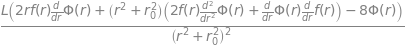

In [28]:
partial_F_contracted[1]

This is the same equation as Eq. (4.17) in the paper, once you set the numerator to zero and integrate.

### Chemical Potential

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fmin
from scipy.special import ellipe
from scipy.special import ellipk

In [30]:
def get_a_b(phi_star):
    a = (1 + 16 * phi_star ** 2) ** (1./4)
    b = np.sqrt((a ** 2 - 1) / 2)
    return a, b

def get_phi_0(phi_star):
    a, b, = get_a_b(phi_star)
    return phi_star * np.cosh(2 / b * ellipk(1 - a ** 2 / b ** 2))

In [31]:
phi_star = np.arange(0.01, 10, 0.025)

In [32]:
phi_0 = get_phi_0(phi_star)

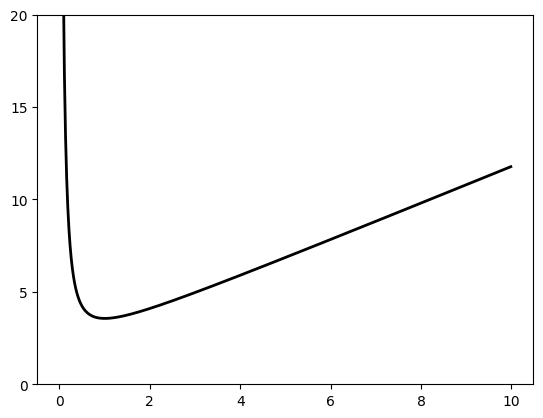

In [33]:
plt.plot(phi_star, phi_0, c='k', lw=2)
plt.yticks([0, 5, 10, 15, 20])
plt.ylim([0, 20]);

Get minimum of function.

In [34]:
fmin(get_phi_0, 1)

Optimization terminated successfully.
         Current function value: 3.563349
         Iterations: 10
         Function evaluations: 20


array([1.00234375])

In [35]:
def get_r0_over_L(phi_star):
    a = (1 + 16 * phi_star ** 2) ** (1./4)
    return np.sqrt((a ** 2 - 1) / 2)

In [36]:
r0_over_L = get_r0_over_L(phi_star)

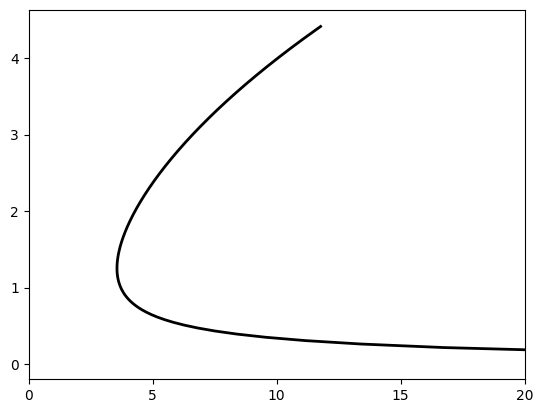

In [37]:
plt.plot(phi_0, r0_over_L, c='k', lw=2)
plt.xticks([0, 5, 10, 15, 20])
plt.xlim([0, 20]);

Plot the difference in the action between the disconnected and connected solutions.

In [38]:
def get_action_connected(phi_star):
    _, b = get_a_b(phi_star)
    X = 1 + 1 / b ** 2
    S = 2 * (X - 1) * ellipe(-X) - (X - 2) * ellipk(-X) + 3 * X * np.sinh(4 * np.sqrt(X - 1) * ellipk(-X)) / (4 * np.sqrt(X - 1))
    return 8 * np.pi ** 2 * S / (X - 1) ** 1.5

In [39]:
def get_action_disconnected(phi_0):
    return 8 * np.pi ** 2 * (1 + 3 * phi_0 ** 2)

In [40]:
S_c = [get_action_connected(ps) for ps in phi_star]
S_d = get_action_disconnected(phi_0)

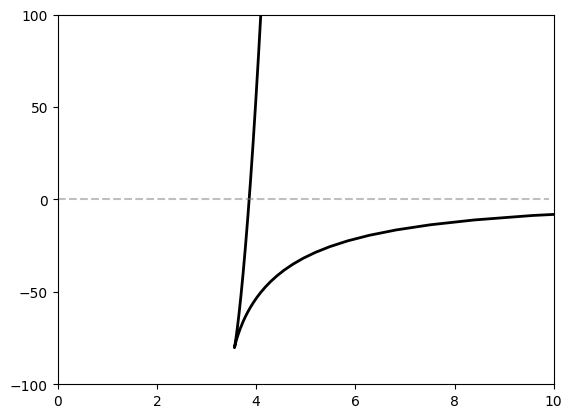

In [41]:
plt.plot(phi_0, 2 * S_d - S_c, c='k', lw=2)
plt.plot(np.arange(0, 10, 0.1), np.zeros(100), '--', c='gray', alpha=0.5)
plt.yticks([-100, -50, 0, 50, 100])
plt.xlim([0, 10])
plt.ylim([-100, 100]);